In [1]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

dataRep = '../data/'
datasetRep = '../data/dataset/'
trainImageRep = '../data/train_images/'
scriptRep = '../'

#Import the scripts
import sys
sys.path.insert(1, os.path.abspath(scriptRep))
import kuzushiji_recognition as kr

unicodeData = pd.read_csv(dataRep+'unicode_translation.csv')
trainData = pd.read_csv(dataRep+'train.csv')
sampleSubData = pd.read_csv(dataRep+'sample_submission.csv')

In [2]:
#Parameters Cell

nbImageTrain = 100
xpixel = 512
ypixel = 512
minSize=32
fill_color=(255, 255, 255)

In [3]:
#Creation of the dataset

imagesId = trainData.image_id.tolist()
labels = trainData.labels.tolist()
poulpe = list(zip(imagesId,labels))
#print(imagesId)
imageTrain = random.choices(poulpe, weights=None, cum_weights=None, k=nbImageTrain)
trainImagesId, trainLabel = list(zip(*imageTrain))
#print(trainImagesId[0])

In [63]:
#Creation of the training segmentation maps
segMaps = np.zeros((nbImageTrain, xpixel, ypixel, 2))

for i in range(nbImageTrain):
    Im = Image.open(trainImageRep + trainImagesId[i] + '.jpg')
    xIm, yIm = Im.size
    dB = kr.createCaracDatabase(trainLabel[i], unicodeData)
    (dB1, dB2) = kr.separateDatabase(dB)
    segMap1 = kr.createSegmentationMap(xIm, yIm, dB1)
    segMap2 = kr.createSegmentationMap(xIm, yIm, dB2)
    cSegMap1 = kr.convertImage(Image.fromarray(segMap1), xpixel, ypixel, gray=True, squared=True)
    cSegMap2 = kr.convertImage(Image.fromarray(segMap2), xpixel, ypixel, gray=True, squared=True)
    cSegMap1 = np.squeeze(np.delete(np.delete(np.array(cSegMap1), 0, axis=2), 0, axis=2))
    cSegMap2 = np.squeeze(np.delete(np.delete(np.array(cSegMap2), 0, axis=2), 0, axis=2))
    cSegMap = np.swapaxes(np.array([cSegMap1,cSegMap2],dtype=np.uint8), 0, 2)
    segMaps[i] = cSegMap
    
#     fig = plt.figure(figsize=(20,20))
#     ax = fig.subplots(2,2)
#     ax1, ax2, ax3, ax4 = ax.ravel()
#     ax1.imshow(segMap1)
#     ax2.imshow(segMap2)
#     ax3.imshow(cSegMap1)
#     ax4.imshow(cSegMap2)
#     plt.tight_layout()

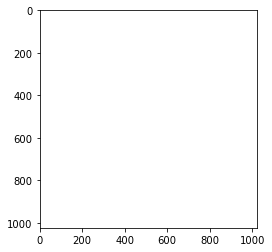

In [5]:
#Creation of the U-Net for segmentation maps

def createModelUNet(dropoutRate, convLayer, denseLayer):
    inputs = Input(, name='input')
    #1st Stage
    conv1a = Conv2D(convLayer, (3, 3), activation='relu', name='conv1a')(inputs)
    drop1a = SpatialDropout2D(dropoutRate, name='drop1a')(conv1a)
    conv1b = Conv2D(convLayer, (3, 3), activation='relu', padding='same', name='conv1b')(drop1a)
    drop1b = SpatialDropout2D(dropoutRate, name='drop1b')(conv1b)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(drop1b)
    
    #2nd Stage
    conv2a = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv2a')(pool1)
    drop2a = SpatialDropout2D(dropoutRate, name='drop2a')(conv2a)
    conv2b = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv2b')(drop2a)
    drop2b = SpatialDropout2D(dropoutRate, name='drop2b')(conv2b)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(drop2b)
    
    #3rd Stage
    conv3a = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv3a')(pool2)
    drop3a = SpatialDropout2D(dropoutRate, name='drop3a')(conv3a)
    conv3b = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv3b')(drop3a)
    drop3b = SpatialDropout2D(dropoutRate, name='drop3b')(conv3b)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(drop3b)
    
    #4th Stage
    conv4a = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv4a')(pool3)
    drop4a = SpatialDropout2D(dropoutRate, name='drop4a')(conv4a)
    conv4b = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv4b')(drop4a)
    drop4b = SpatialDropout2D(dropoutRate, name='drop4b')(conv4b)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(drop4b)
    
    #5th Stage
    conv5a = Conv2D(convLayer*16, (3, 3), activation='relu', name='conv5a')(pool4)
    drop5a = SpatialDropout2D(dropoutRate, name='drop5a')(conv5a)
    conv5b = Conv2D(convLayer*16, (3, 3), activation='relu', name='conv5b')(drop5a)
    drop5b = SpatialDropout2D(dropoutRate, name='drop5b')(conv5b)
    
    #6th Stage
    up6 = Conv2DTranspose(convLayerr*8, (3, 3), activation='relu', name='conv6a')(drop5b)
    merge6 = concatenate([drop4b, up6], axis=3, name='merge6')
    conv6b = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv6b')(merge6)
    drop6b = SpatialDropout2D(dropoutRate, name='drop6b')(conv6b)
    conv6c = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv6c')(drop6b)
    drop6c = SpatialDropout2D(dropoutRate, name='drop6c')(conv6c)
    
    #7th Stage
    up7 = Conv2DTranspose(convLayer*4, (3, 3), activation='relu', name='conv7a')(drop6c)
    merge7 = concatenate([drop3b, up7], axis=3, name='merge7')
    conv7b = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv7b')(merge7)
    drop7b = SpatialDropout2D(dropoutRate, name='drop7b')(conv7b)
    conv7c = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv7c')(drop7b)
    drop7c = SpatialDropout2D(dropoutRate, name='drop7c')(conv7c)
    
    #8th Stage
    up8 = Conv2DTranspose(convLayerr*2, (3, 3), activation='relu', name='conv8a')(drop7c)
    merge8 = concatenate([drop2b, up8], axis=3, name='merge8')
    conv8b = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv8b')(merge8)
    drop8b = SpatialDropout2D(dropoutRate, name='drop8b')(conv8b)
    conv8c = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv8c')(drop8b)
    drop8c = SpatialDropout2D(dropoutRate, name='drop8c')(conv8c)
    
    #9th Stage
    up9 = Conv2DTranspose(convLayer, (3, 3), activation='relu', name='conv9a')(drop8c)
    merge9 = concatenate([drop1b, up9], axis=3, name='merge9')
    conv9b = Conv2D(convLayer, (3, 3), activation='relu', name='conv9b')(merge9)
    drop9b = SpatialDropout2D(dropoutRate, name='drop9b')(conv9b)
    conv9c = Conv2D(convLayer, (3, 3), activation='relu', name='conv9c')(drop9b)
    drop9c = SpatialDropout2D(dropoutRate, name='drop9c')(conv9c)
    
    #10th Stage
    conv10 = Conv2D(convLayer, (3, 3), activation='relu', name='conv10')(drop9c)
    
    Model(input=inputs, output=conv10)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
imgSeg3 = Image.new('L', (xpixel, ypixel), 255)
plt.imshow(imgSeg3,cmap='bone',vmin=0, vmax=255)

In [6]:
unicodeData = pd.read_csv(dataRep+'unicode_translation.csv')
kr.createCaracDatabase(trainLabel[0], unicodeData)

,caracter,position,size
0,へ,"(305, 1243)","(54, 26)"
1,コ,"(143, 1126)","(46, 35)"
2,ば,"(1662, 2205)","(57, 37)"
3,か,"(1748, 2347)","(26, 38)"
4,ヨ,"(1280, 2142)","(39, 39)"
...,...,...,...
251,な,"(1455, 445)","(68, 134)"
252,咎,"(1200, 737)","(119, 142)"
253,く,"(135, 2903)","(43, 143)"
254,多,"(324, 2477)","(94, 154)"


In [11]:
dB1

,caracter,position,size
0,い,"(983, 3616)","(109, 57)"
2,ら,"(1880, 2185)","(45, 75)"
4,小,"(1828, 3811)","(111, 76)"
6,の,"(853, 3416)","(72, 80)"
8,か,"(1747, 1400)","(80, 81)"
...,...,...,...
120,露,"(1061, 1284)","(109, 225)"
122,銚,"(74, 3093)","(165, 232)"
124,中,"(103, 921)","(120, 237)"
126,髪,"(1854, 1259)","(151, 251)"


In [8]:
dB2

,caracter,position,size
1,口,"(1847, 3921)","(81, 68)"
3,か,"(1986, 2929)","(57, 75)"
5,た,"(1864, 3017)","(83, 77)"
7,わ,"(1868, 2081)","(57, 81)"
9,さ,"(2075, 2753)","(64, 85)"
...,...,...,...
121,鱠,"(1903, 728)","(247, 231)"
123,鉢,"(329, 3016)","(203, 232)"
125,平,"(1375, 2787)","(107, 243)"
127,飯,"(1439, 1800)","(203, 252)"


In [9]:
dB

,caracter,position,size
0,い,"(983, 3616)","(109, 57)"
1,口,"(1847, 3921)","(81, 68)"
2,ら,"(1880, 2185)","(45, 75)"
3,か,"(1986, 2929)","(57, 75)"
4,小,"(1828, 3811)","(111, 76)"
...,...,...,...
125,平,"(1375, 2787)","(107, 243)"
126,髪,"(1854, 1259)","(151, 251)"
127,飯,"(1439, 1800)","(203, 252)"
128,す,"(2272, 2021)","(80, 291)"


In [60]:
cSegMap1 = kr.convertImage(Image.fromarray(segMap1), xpixel, ypixel, gray=True, squared=True)
cSegMap2 = kr.convertImage(Image.fromarray(segMap2), xpixel, ypixel, gray=True, squared=True)
cSegMap1 = np.array(cSegMap1)
cSegMap2 = np.array(cSegMap2)

In [61]:
cSegMap1 = np.squeeze(np.delete(np.delete(np.array(cSegMap1), 0, axis=2), 0, axis=2))
cSegMap2 = np.squeeze(np.delete(np.delete(np.array(cSegMap2), 0, axis=2), 0, axis=2))
cSegMap = np.swapaxes(np.array([cSegMap1,cSegMap2],dtype=np.uint8), 0, 2)
print(cSegMap.shape)

(512, 512, 2)


In [58]:
segMaps = np.zeros((nbImageTrain, xpixel, ypixel, 2))
segMaps[0].shape


(512, 512, 2)